In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

import os
import csv
import numpy as np
import glob

from sklearn.metrics import accuracy_score, f1_score

## Load Model

In [2]:
def search_in_labels(filename, label_dict):
    base_name = os.path.splitext(filename)[0]
    
    if "_logmel" in base_name:
        base_name = base_name.replace("_logmel", "")
    if "_flipped" in base_name:
        base_name = base_name.replace("_flipped", "")
    
    parts = base_name.split("_")
    if len(parts) >= 2:
        audio_filename = f"{parts[0]}_{parts[1]}.wav"
    else:
        audio_filename = f"{base_name}.wav"
    
    return label_dict.get(audio_filename, None)

In [3]:
class SpectrogramDataset(Dataset):
        def __init__(self, image_paths, label_dict, transform=None):
            self.image_paths = image_paths
            self.label_dict = label_dict
            
            self.transform = transforms.Compose([
                transforms.Resize((128, 42)),
                transforms.ToTensor()
            ])
        
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            filename = os.path.basename(image_path)
            label = search_in_labels(filename, self.label_dict)
            label_num = 1 if label == "C" else 0
            
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
            
            return image, label_num

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)

class SupervisedContrastiveCNN(nn.Module):

    def __init__(self, input_channels=3, projection_dim=128, feature_dim=512):
        super(SupervisedContrastiveCNN, self).__init__()
        
        self.feature_extractor = self._build_feature_extractor(input_channels)
        
        self.feature_dim = self._get_feature_dim(input_channels)
        
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, projection_dim),
            L2Norm(dim=1) 
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
        
    def _build_feature_extractor(self, input_channels):
        return nn.Sequential(
            # 1st Conv Block
            nn.Conv2d(input_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            
            # 2nd Conv Block
            nn.Conv2d(128, 256, kernel_size=4, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 3rd Conv Block
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Global Average Pooling
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
    
    def _get_feature_dim(self, input_channels):
        with torch.no_grad():
            x = torch.randn(1, input_channels, 128, 42)
            features = self.feature_extractor(x)
            return features.shape[1]
    
    def forward(self, x, return_features=False):

        features = self.feature_extractor(x)
        
        logits = self.classifier(features)
        
        if return_features:
            projections = self.projection_head(features)
            return logits.squeeze(), projections, features
        else:
            return logits.squeeze()



class SupervisedContrastiveLoss(nn.Module):

    def __init__(self, temperature=0.1, minority_weight=2.0):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.minority_weight = minority_weight
        
    def forward(self, projections, labels):
  
        device = projections.device
        batch_size = projections.shape[0]
        
        similarity_matrix = torch.matmul(projections, projections.T) / self.temperature
        
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        mask = mask - torch.eye(batch_size).to(device)
        
        exp_sim = torch.exp(similarity_matrix)
        
        pos_sim = exp_sim * mask
        
        neg_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        all_sim = exp_sim * neg_mask
        
        losses = []
        for i in range(batch_size):
            if mask[i].sum() > 0: 
                pos_sum = pos_sim[i].sum()
                neg_sum = all_sim[i].sum()
                
                if neg_sum > 0:
                    loss_i = -torch.log(pos_sum / neg_sum)
                    
                    if labels[i] == 1:  
                        loss_i = loss_i * self.minority_weight
                    
                    losses.append(loss_i)
        
        if len(losses) > 0:
            return torch.stack(losses).mean()
        else:
            return torch.tensor(0.0).to(device)

class CombinedLoss(nn.Module):
    def __init__(self, classification_loss, contrastive_loss, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.classification_loss = classification_loss
        self.contrastive_loss = contrastive_loss
        self.alpha = alpha  
        
    def forward(self, logits, projections, labels):
        cls_loss = self.classification_loss(logits, labels.float())
        
        cont_loss = self.contrastive_loss(projections, labels)
        
        total_loss = (1 - self.alpha) * cls_loss + self.alpha * cont_loss
        
        return total_loss, cls_loss, cont_loss

    
class ContrastiveSpectrogramDataset(Dataset):
    def __init__(self, image_paths, label_dict, is_training=False, num_views=2):
        self.image_paths = image_paths
        self.label_dict = label_dict
        self.is_training = is_training
        self.num_views = num_views
        
        self.base_transform = transforms.Compose([
            transforms.Resize((128, 42)),
            transforms.ToTensor()
        ])
        
        self.strong_transform = transforms.Compose([
            transforms.Resize((128, 42)),
            transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.1))
        ])
        
        self.cold_transform = transforms.Compose([
            transforms.Resize((128, 42)),
            transforms.RandomAffine(degrees=0, translate=(0.3, 0)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.08))
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path)
        label = search_in_labels(filename, self.label_dict)
        label_num = 1 if label == "C" else 0
        
        image = Image.open(image_path).convert("RGB")
        
        if self.is_training:
            views = []
            
            views.append(self.base_transform(image))
            
            for _ in range(self.num_views - 1):
                if label == "C":  
                    augmented = self.cold_transform(image)
                else:
                    augmented = self.strong_transform(image)
                views.append(augmented)
            
            return views, label_num
        else:
            return self.base_transform(image), label_num
        

In [4]:
label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]

Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3593908.16it/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load weights from the pretrained model
model = SupervisedContrastiveCNN().to(device)
pretrained_model_path = "../best_contrastive_model_sampling.pth"
model.load_state_dict(torch.load(pretrained_model_path))
model

SupervisedContrastiveCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (projection_head): Sequential(
    (0): L

In [6]:
# Create a dataset and dataloader for evaluation
data_split = ["train_files", "devel_files"]
img_dir = "../spectrogram_images/log_mel"

def collect_image_paths(split_name):
        sub_dir = os.path.join(img_dir, split_name)
        print(f"🔍 Looking for images in: {sub_dir}")
        
        if not os.path.exists(sub_dir):
            print(f"❌ Directory does not exist: {sub_dir}")
            return []
        
        png_files = glob.glob(os.path.join(sub_dir, "*.png"))
        print(f"📁 Found {len(png_files)} PNG files in {split_name}")
        
        return png_files
    

print("🚀 Collecting image paths...")
train_image_paths = collect_image_paths("train_files")
devel_image_paths = collect_image_paths("devel_files")

devel_dataset = SpectrogramDataset(devel_image_paths, label_dict)
devel_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

🚀 Collecting image paths...
🔍 Looking for images in: ../spectrogram_images/log_mel\train_files
📁 Found 10475 PNG files in train_files
🔍 Looking for images in: ../spectrogram_images/log_mel\devel_files
📁 Found 10607 PNG files in devel_files


## Test

In [7]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

probs = []   
labels = []

model.eval()
with torch.no_grad():
    for X, y in devel_loader:
        logits = model(X.to(device)).squeeze()
        p = torch.sigmoid(logits).cpu().numpy()
        probs.extend(p)
        labels.extend(y.numpy())

probs = np.array(probs)
labels = np.array(labels)

best_t, best_uar = 0.5, 0
best_f1 = 0

print("🎯 Threshold optimization using UAR:")
print("-" * 50)

for t in np.linspace(0.1, 0.9, 81):
    preds = (probs > t).astype(int)
    
    uar = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds)
    
    if uar > best_uar:
        best_uar = uar
        best_t = t
        best_f1 = f1

print(f"🏆 Best Threshold = {best_t:.2f}")
print(f"📊 UAR = {best_uar:.3f}")

🎯 Threshold optimization using UAR:
--------------------------------------------------
🏆 Best Threshold = 0.33
📊 UAR = 0.749


In [8]:
test_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

test_preds = []
test_labels = []

threshold = best_t

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))


Testing: 100%|██████████████████████████████████████████| 10607/10607 [01:01<00:00, 173.10samples/s]


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score

uar = recall_score(test_labels, test_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   F1 Score: {f1:.4f}")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(test_labels)) > 1 and len(set(test_preds)) > 1:
    cm = confusion_matrix(test_labels, test_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")
    
    manual_uar = np.mean(class_recalls)
    print(f"\n✅ UAR Verification:")
    print(f"   sklearn UAR: {uar:.4f}")
    print(f"   Manual UAR:  {manual_uar:.4f}")
    print(f"   Match: {'✓' if abs(uar - manual_uar) < 0.0001 else '✗'}")


📈 PERFORMANCE METRICS:
   F1 Score: 0.2537
   UAR (Unweighted Average Recall): 0.7487

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.8856
   Class 1 (Cold): 0.6118

✅ UAR Verification:
   sklearn UAR: 0.7487
   Manual UAR:  0.7487
   Match: ✓


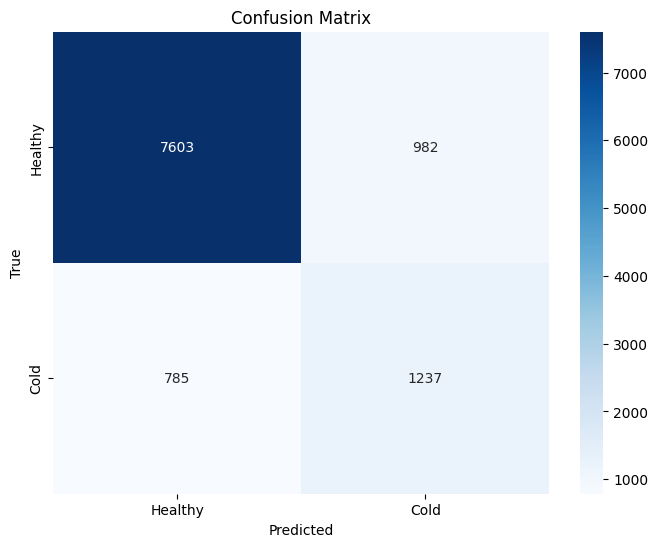

In [10]:
# visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names=['Healthy', 'Cold'])

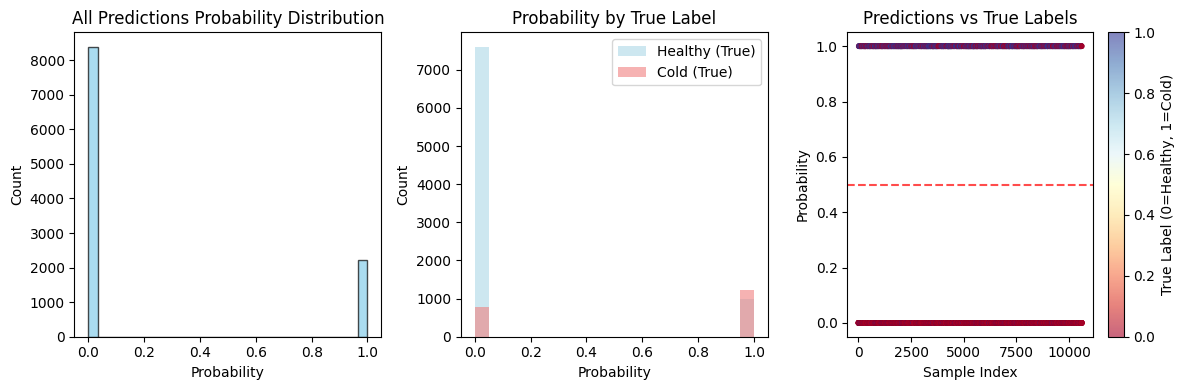

In [11]:

val_probs = np.array(test_preds)
val_labels = np.array(test_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

healthy_probs = val_probs[val_labels == 0]
cold_probs    = val_probs[val_labels == 1]

plt.subplot(1, 3, 2)
plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs,    bins=20, alpha=0.6, label='Cold (True)',    color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
            cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label (0=Healthy, 1=Cold)')

plt.tight_layout()
plt.show()



🎨 Generating fancy UAR visualizations...


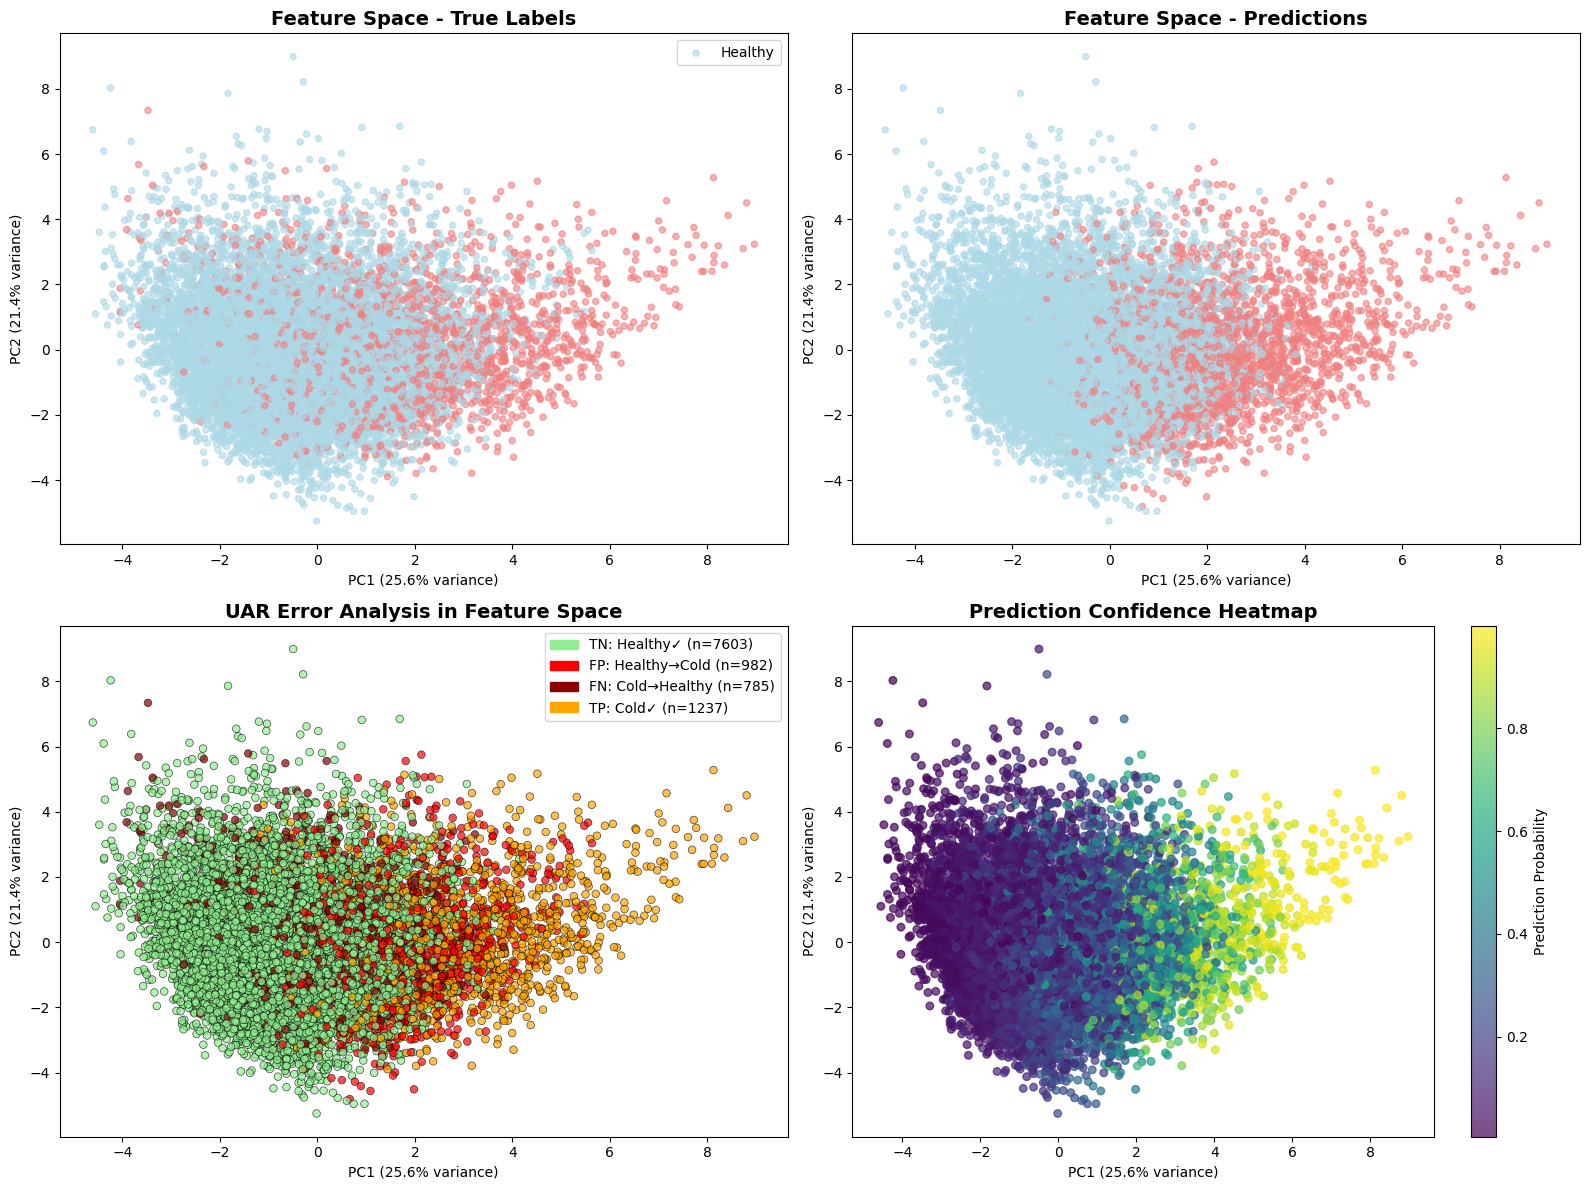

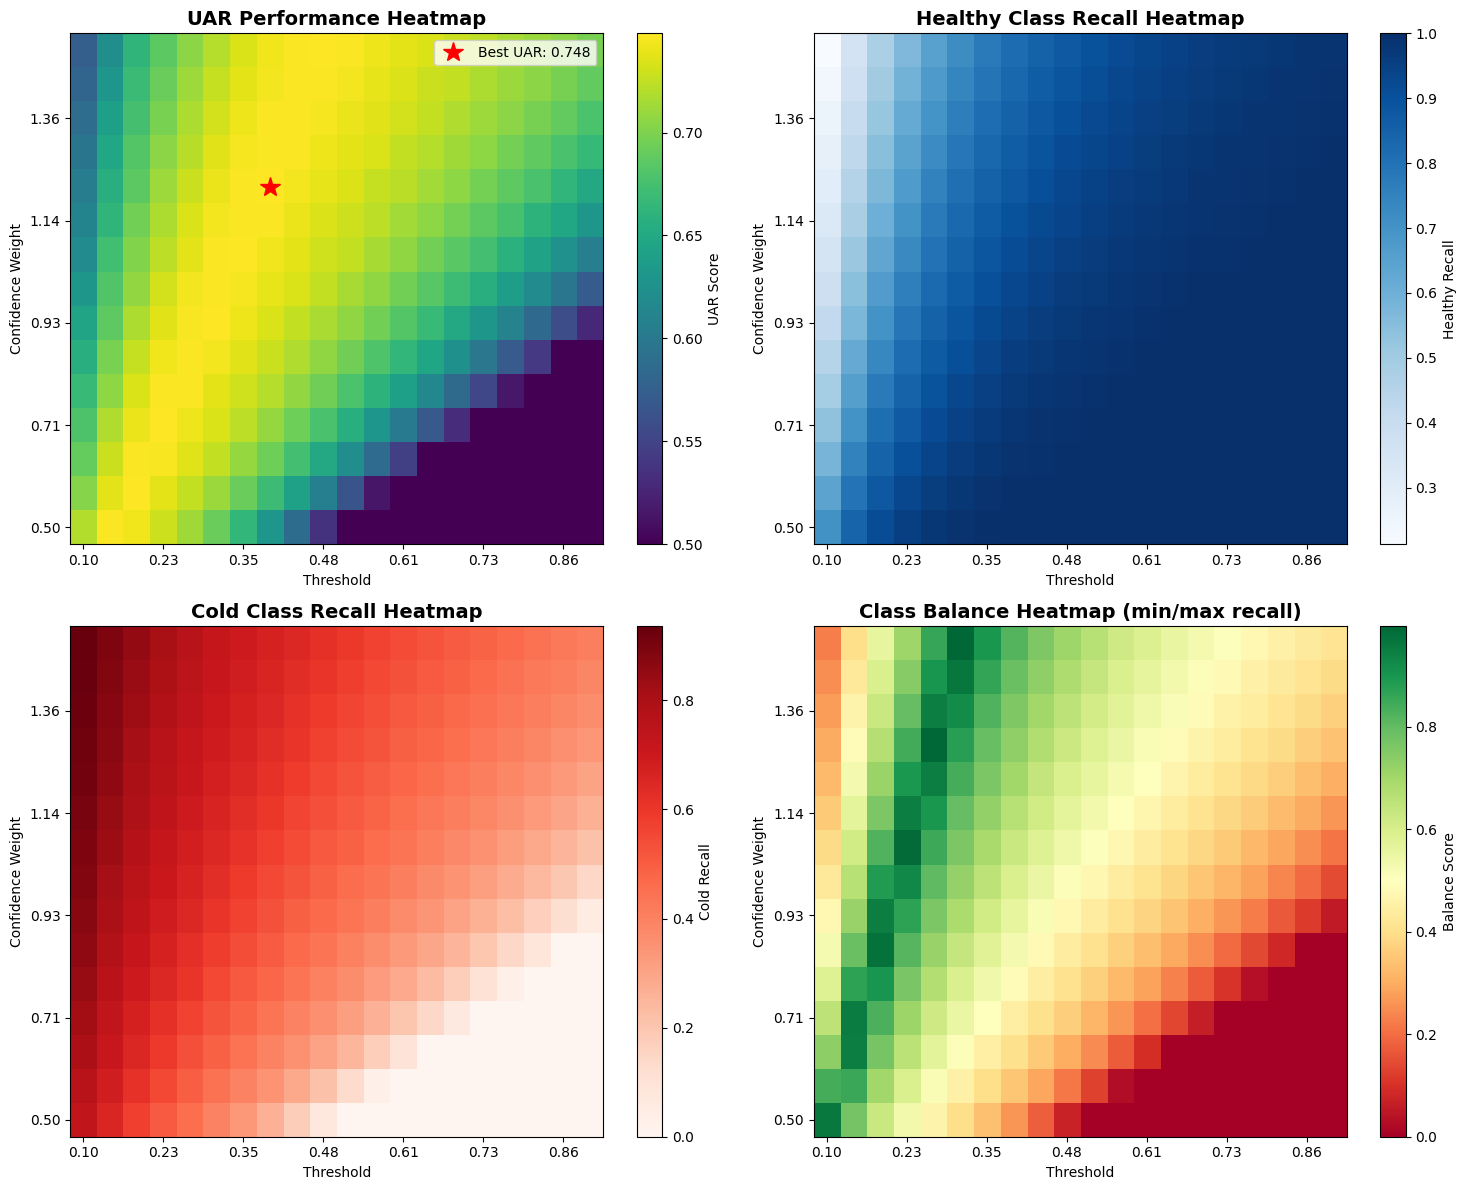

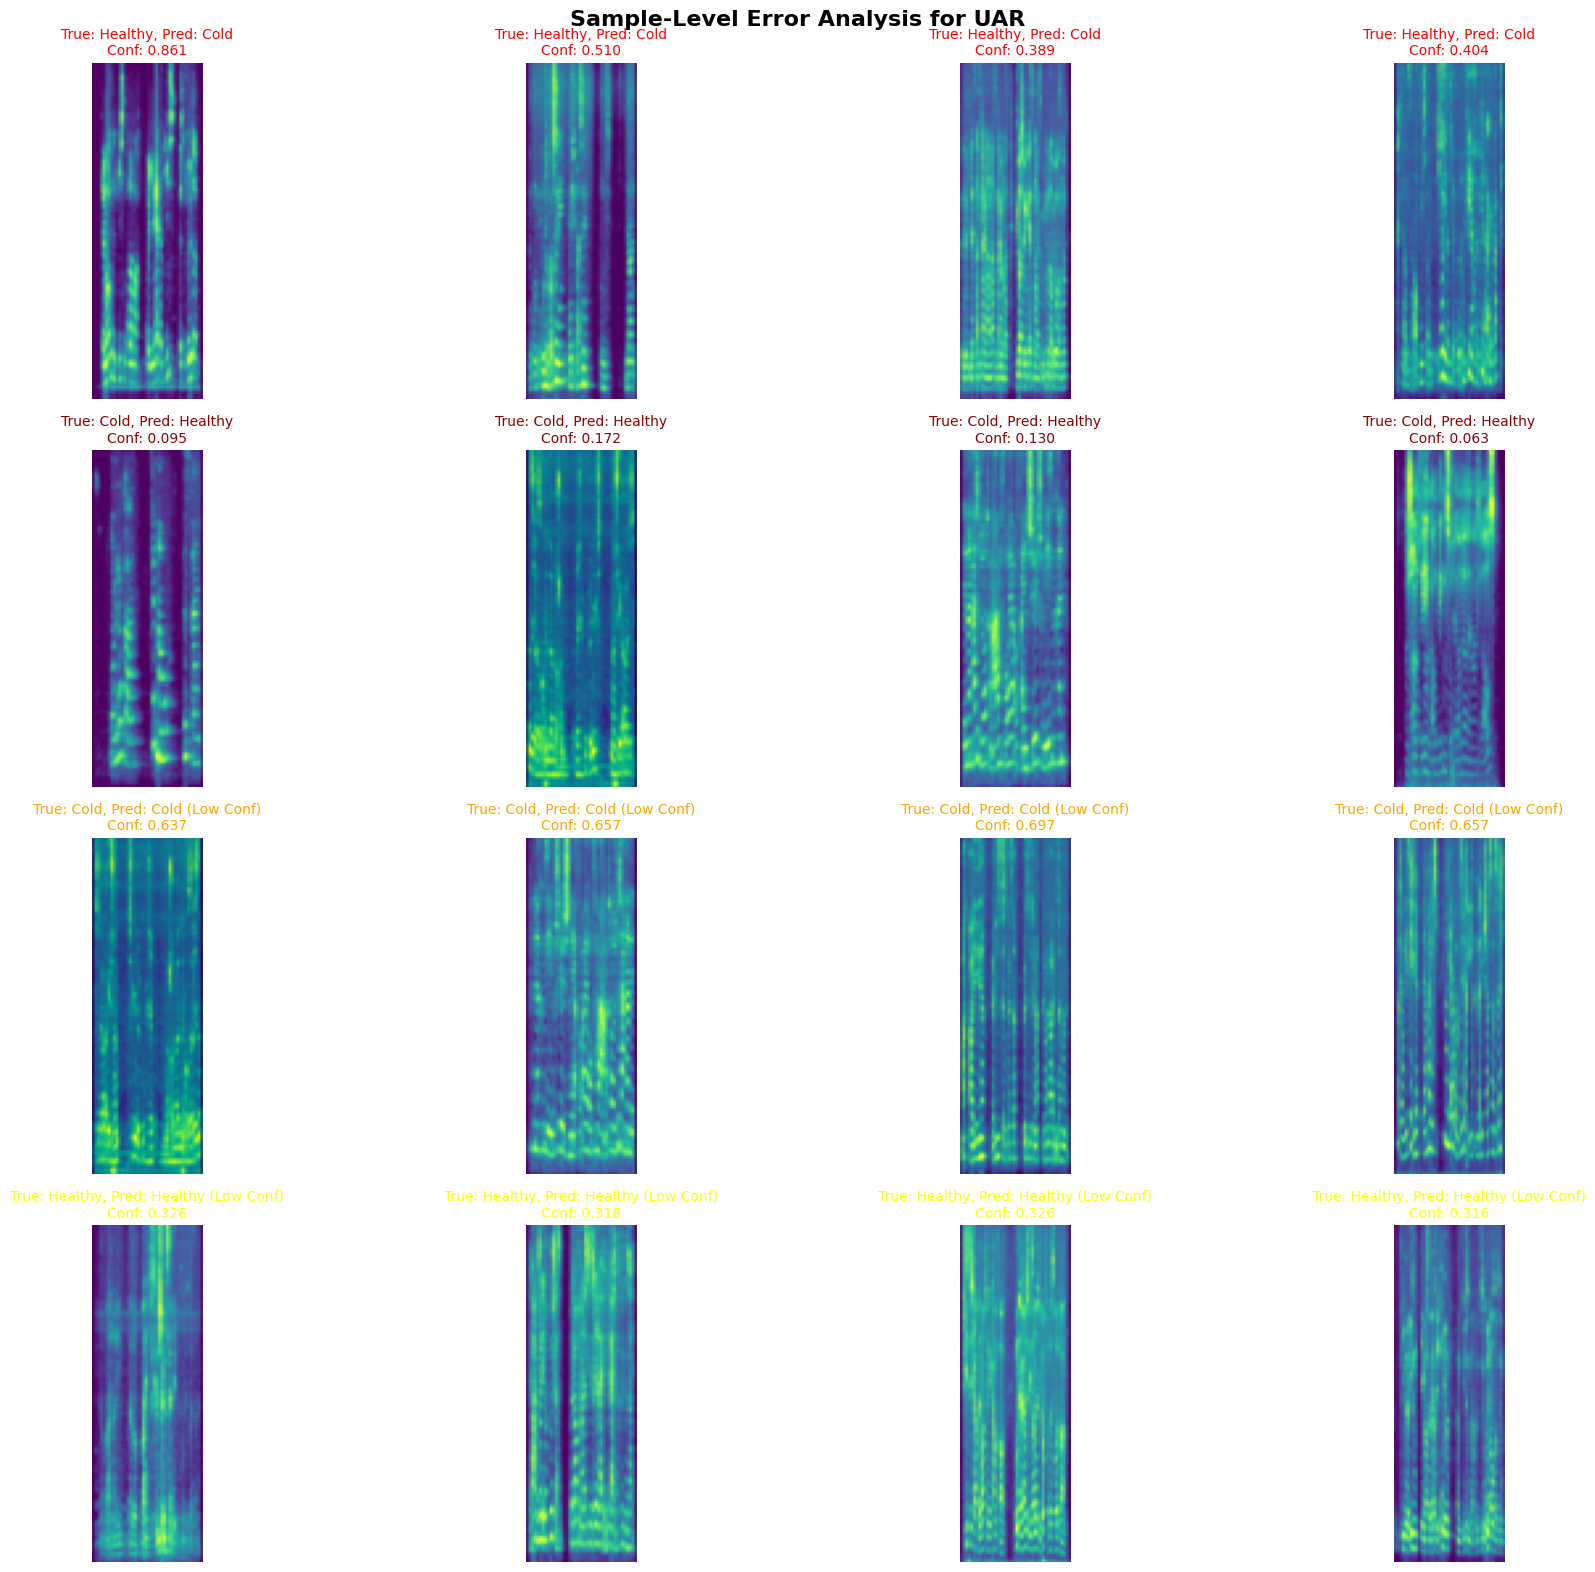

C:\Users\10857\AppData\Local\Temp\ipykernel_25476\4077492132.py:303: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax3.boxplot(box_data, labels=['TN', 'FP', 'FN', 'TP'], patch_artist=True)


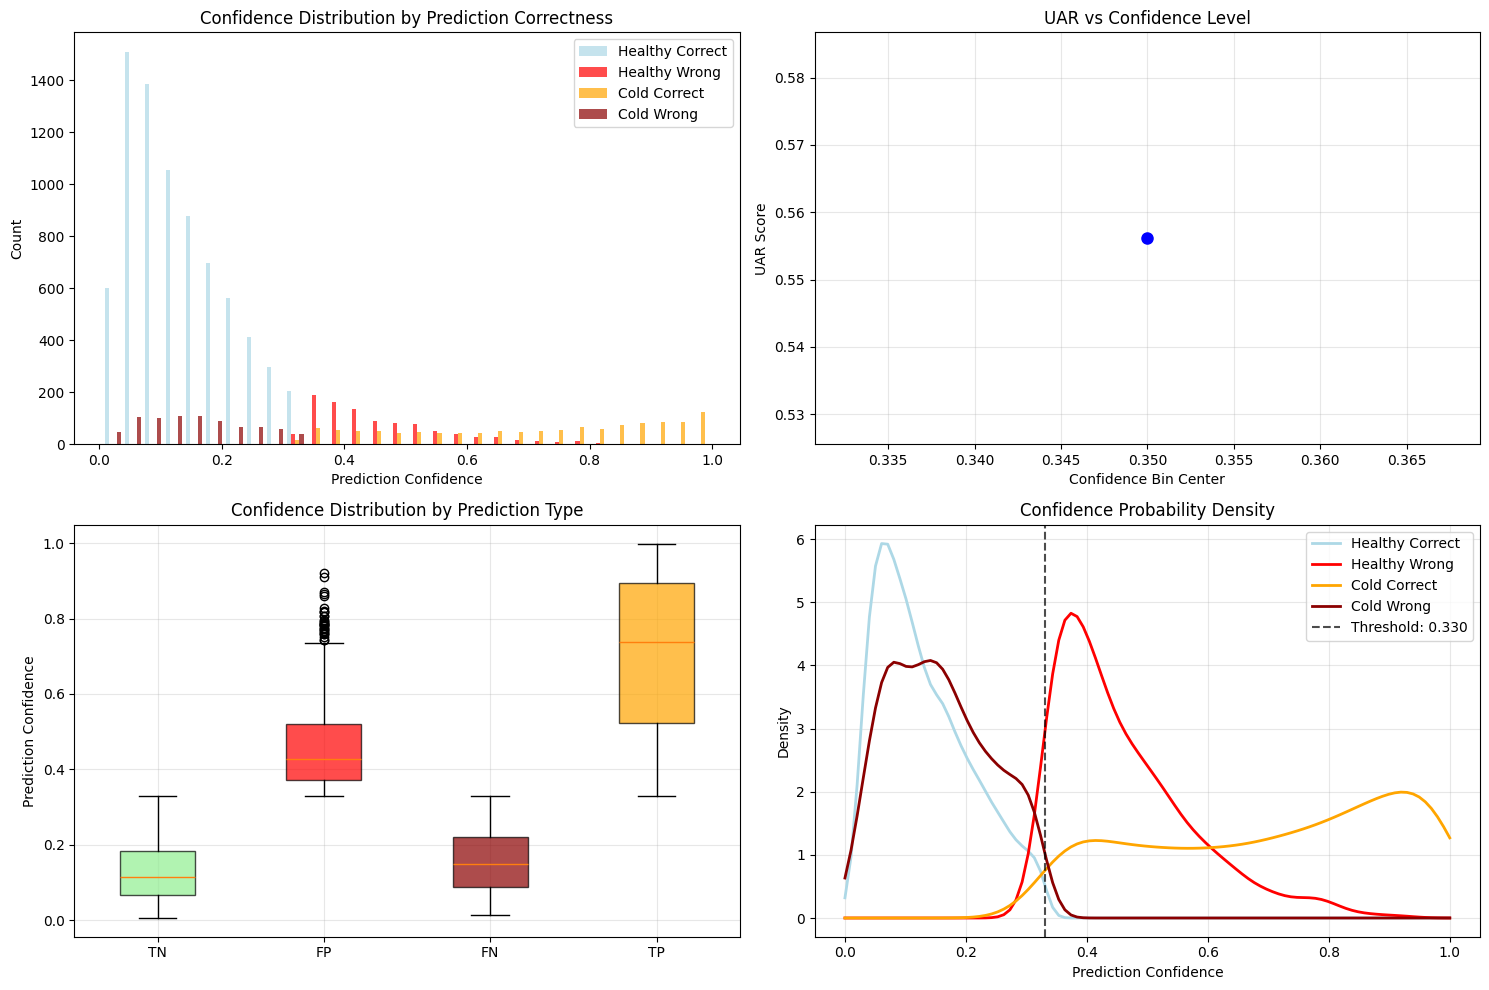

✨ All fancy visualizations completed!


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import torch
from torchvision import transforms
import cv2

# 1. 特征空间可视化 + UAR分析
def visualize_feature_space_with_uar(model, test_loader, device):
    """可视化特征空间并分析UAR相关的错误模式"""
    
    model.eval()
    features_list = []
    labels_list = []
    predictions_list = []
    probs_list = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            logits, projections, features = model(batch_X, return_features=True)
            probs = torch.sigmoid(logits)
            preds = (probs > best_t).long()
            
            features_list.append(features.cpu().numpy())
            labels_list.extend(batch_y.numpy())
            predictions_list.extend(preds.cpu().numpy())
            probs_list.extend(probs.cpu().numpy())
    
    # 合并所有特征
    all_features = np.vstack(features_list)
    all_labels = np.array(labels_list)
    all_predictions = np.array(predictions_list)
    all_probs = np.array(probs_list)
    
    # PCA降维
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(all_features)
    
    # 创建UAR错误分析图
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 真实标签分布
    colors = ['lightblue' if label == 0 else 'lightcoral' for label in all_labels]
    ax1.scatter(features_2d[:, 0], features_2d[:, 1], c=colors, alpha=0.6, s=20)
    ax1.set_title('Feature Space - True Labels', fontsize=14, fontweight='bold')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.legend(['Healthy', 'Cold'])
    
    # 2. 预测结果分布
    pred_colors = ['lightblue' if pred == 0 else 'lightcoral' for pred in all_predictions]
    ax2.scatter(features_2d[:, 0], features_2d[:, 1], c=pred_colors, alpha=0.6, s=20)
    ax2.set_title('Feature Space - Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    
    # 3. UAR错误分析热图
    # 标记不同类型的预测错误
    error_types = []
    for true_label, pred_label in zip(all_labels, all_predictions):
        if true_label == 0 and pred_label == 0:
            error_types.append('TN')  # True Negative (Healthy correctly predicted)
        elif true_label == 0 and pred_label == 1:
            error_types.append('FP')  # False Positive (Healthy predicted as Cold)
        elif true_label == 1 and pred_label == 0:
            error_types.append('FN')  # False Negative (Cold predicted as Healthy)
        else:
            error_types.append('TP')  # True Positive (Cold correctly predicted)
    
    # 为每种错误类型设置颜色
    error_color_map = {'TN': 'lightgreen', 'FP': 'red', 'FN': 'darkred', 'TP': 'orange'}
    error_colors = [error_color_map[et] for et in error_types]
    
    scatter = ax3.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=error_colors, alpha=0.7, s=30, edgecolors='black', linewidth=0.5)
    ax3.set_title('UAR Error Analysis in Feature Space', fontsize=14, fontweight='bold')
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    
    # 添加图例
    import matplotlib.patches as mpatches
    tn_patch = mpatches.Patch(color='lightgreen', label=f'TN: Healthy✓ (n={error_types.count("TN")})')
    fp_patch = mpatches.Patch(color='red', label=f'FP: Healthy→Cold (n={error_types.count("FP")})')
    fn_patch = mpatches.Patch(color='darkred', label=f'FN: Cold→Healthy (n={error_types.count("FN")})')
    tp_patch = mpatches.Patch(color='orange', label=f'TP: Cold✓ (n={error_types.count("TP")})')
    ax3.legend(handles=[tn_patch, fp_patch, fn_patch, tp_patch], loc='upper right')
    
    # 4. 预测置信度热图
    im = ax4.scatter(features_2d[:, 0], features_2d[:, 1], 
                    c=all_probs, cmap='viridis', alpha=0.7, s=30)
    ax4.set_title('Prediction Confidence Heatmap', fontsize=14, fontweight='bold')
    ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(im, ax=ax4, label='Prediction Probability')
    
    plt.tight_layout()
    return fig

# 2. UAR性能热图分析
def plot_uar_performance_heatmap(all_probs, all_labels):
    """创建UAR性能热图"""
    
    # 不同阈值下的性能分析
    thresholds = np.linspace(0.1, 0.9, 20)
    confidence_weights = np.linspace(0.5, 1.5, 15)
    
    uar_matrix = np.zeros((len(confidence_weights), len(thresholds)))
    healthy_recall_matrix = np.zeros((len(confidence_weights), len(thresholds)))
    cold_recall_matrix = np.zeros((len(confidence_weights), len(thresholds)))
    
    for i, weight in enumerate(confidence_weights):
        for j, threshold in enumerate(thresholds):
            # 应用置信度权重
            weighted_probs = np.clip(all_probs * weight, 0, 1)
            predictions = (weighted_probs > threshold).astype(int)
            
            # 计算混淆矩阵
            cm = confusion_matrix(all_labels, predictions, labels=[0, 1])
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                healthy_recall = tn / (tn + fp) if (tn + fp) > 0 else 0
                cold_recall = tp / (fn + tp) if (fn + tp) > 0 else 0
                uar = (healthy_recall + cold_recall) / 2
            else:
                healthy_recall = cold_recall = uar = 0
            
            uar_matrix[i, j] = uar
            healthy_recall_matrix[i, j] = healthy_recall
            cold_recall_matrix[i, j] = cold_recall
    
    # 创建热图
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # UAR热图
    im1 = ax1.imshow(uar_matrix, cmap='viridis', aspect='auto', origin='lower')
    ax1.set_title('UAR Performance Heatmap', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Confidence Weight')
    ax1.set_xticks(range(0, len(thresholds), 3))
    ax1.set_xticklabels([f'{thresholds[i]:.2f}' for i in range(0, len(thresholds), 3)])
    ax1.set_yticks(range(0, len(confidence_weights), 3))
    ax1.set_yticklabels([f'{confidence_weights[i]:.2f}' for i in range(0, len(confidence_weights), 3)])
    plt.colorbar(im1, ax=ax1, label='UAR Score')
    
    # 找到最佳UAR点
    best_uar_idx = np.unravel_index(np.argmax(uar_matrix), uar_matrix.shape)
    ax1.plot(best_uar_idx[1], best_uar_idx[0], 'r*', markersize=15, 
             label=f'Best UAR: {uar_matrix[best_uar_idx]:.3f}')
    ax1.legend()
    
    # Healthy Recall热图
    im2 = ax2.imshow(healthy_recall_matrix, cmap='Blues', aspect='auto', origin='lower')
    ax2.set_title('Healthy Class Recall Heatmap', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Confidence Weight')
    ax2.set_xticks(range(0, len(thresholds), 3))
    ax2.set_xticklabels([f'{thresholds[i]:.2f}' for i in range(0, len(thresholds), 3)])
    ax2.set_yticks(range(0, len(confidence_weights), 3))
    ax2.set_yticklabels([f'{confidence_weights[i]:.2f}' for i in range(0, len(confidence_weights), 3)])
    plt.colorbar(im2, ax=ax2, label='Healthy Recall')
    
    # Cold Recall热图
    im3 = ax3.imshow(cold_recall_matrix, cmap='Reds', aspect='auto', origin='lower')
    ax3.set_title('Cold Class Recall Heatmap', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('Confidence Weight')
    ax3.set_xticks(range(0, len(thresholds), 3))
    ax3.set_xticklabels([f'{thresholds[i]:.2f}' for i in range(0, len(thresholds), 3)])
    ax3.set_yticks(range(0, len(confidence_weights), 3))
    ax3.set_yticklabels([f'{confidence_weights[i]:.2f}' for i in range(0, len(confidence_weights), 3)])
    plt.colorbar(im3, ax=ax3, label='Cold Recall')
    
    # UAR平衡性分析
    balance_matrix = np.minimum(healthy_recall_matrix, cold_recall_matrix) / np.maximum(healthy_recall_matrix, cold_recall_matrix)
    balance_matrix = np.nan_to_num(balance_matrix)
    
    im4 = ax4.imshow(balance_matrix, cmap='RdYlGn', aspect='auto', origin='lower')
    ax4.set_title('Class Balance Heatmap (min/max recall)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Confidence Weight')
    ax4.set_xticks(range(0, len(thresholds), 3))
    ax4.set_xticklabels([f'{thresholds[i]:.2f}' for i in range(0, len(thresholds), 3)])
    ax4.set_yticks(range(0, len(confidence_weights), 3))
    ax4.set_yticklabels([f'{confidence_weights[i]:.2f}' for i in range(0, len(confidence_weights), 3)])
    plt.colorbar(im4, ax=ax4, label='Balance Score')
    
    plt.tight_layout()
    return fig

# 3. 样本级别的错误分析可视化
def visualize_sample_level_errors(model, test_loader, device, num_samples=20):
    """可视化样本级别的预测错误"""
    
    model.eval()
    error_samples = {'FP': [], 'FN': [], 'TP_low_conf': [], 'TN_low_conf': []}
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            logits = model(batch_X).squeeze()
            probs = torch.sigmoid(logits)
            preds = (probs > best_t).long()
            
            for i in range(len(batch_X)):
                image = batch_X[i].cpu()
                true_label = batch_y[i].item()
                pred_label = preds[i].item()
                confidence = probs[i].item()
                
                # 收集不同类型的错误样本
                if true_label == 0 and pred_label == 1:  # False Positive
                    error_samples['FP'].append((image, confidence, f'True: Healthy, Pred: Cold'))
                elif true_label == 1 and pred_label == 0:  # False Negative
                    error_samples['FN'].append((image, confidence, f'True: Cold, Pred: Healthy'))
                elif true_label == 1 and pred_label == 1 and confidence < 0.7:  # Low confidence TP
                    error_samples['TP_low_conf'].append((image, confidence, f'True: Cold, Pred: Cold (Low Conf)'))
                elif true_label == 0 and pred_label == 0 and confidence > 0.3:  # Low confidence TN
                    error_samples['TN_low_conf'].append((image, confidence, f'True: Healthy, Pred: Healthy (Low Conf)'))
    
    # 可视化错误样本
    fig, axes = plt.subplots(4, num_samples//4, figsize=(20, 16))
    
    sample_types = ['FP', 'FN', 'TP_low_conf', 'TN_low_conf']
    colors = ['red', 'darkred', 'orange', 'yellow']
    
    for row, (sample_type, color) in enumerate(zip(sample_types, colors)):
        samples = error_samples[sample_type][:num_samples//4]
        
        for col, (image, confidence, label) in enumerate(samples):
            if col >= num_samples//4:
                break
                
            ax = axes[row, col]
            
            # 转换图像以便显示
            img_display = image.permute(1, 2, 0).numpy()
            img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
            
            ax.imshow(img_display)
            ax.set_title(f'{label}\nConf: {confidence:.3f}', fontsize=10, color=color)
            ax.axis('off')
    
    plt.suptitle('Sample-Level Error Analysis for UAR', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# 4. 置信度分布与UAR关系
def plot_confidence_uar_relationship(all_probs, all_labels, all_predictions):
    """分析置信度分布与UAR的关系"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 置信度分布by类别和预测结果
    healthy_correct = all_probs[(all_labels == 0) & (all_predictions == 0)]
    healthy_wrong = all_probs[(all_labels == 0) & (all_predictions == 1)]
    cold_correct = all_probs[(all_labels == 1) & (all_predictions == 1)]
    cold_wrong = all_probs[(all_labels == 1) & (all_predictions == 0)]
    
    ax1.hist([healthy_correct, healthy_wrong, cold_correct, cold_wrong], 
             bins=30, alpha=0.7, 
             label=['Healthy Correct', 'Healthy Wrong', 'Cold Correct', 'Cold Wrong'],
             color=['lightblue', 'red', 'orange', 'darkred'])
    ax1.set_title('Confidence Distribution by Prediction Correctness')
    ax1.set_xlabel('Prediction Confidence')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # 2. 按置信度区间的UAR变化
    conf_bins = np.linspace(0, 1, 11)
    uars_by_conf = []
    conf_centers = []
    
    for i in range(len(conf_bins)-1):
        mask = (all_probs >= conf_bins[i]) & (all_probs < conf_bins[i+1])
        if mask.sum() > 10:  # 确保有足够样本
            subset_labels = all_labels[mask]
            subset_preds = all_predictions[mask]
            
            if len(np.unique(subset_labels)) > 1 and len(np.unique(subset_preds)) > 1:
                uar = recall_score(subset_labels, subset_preds, average='macro')
                uars_by_conf.append(uar)
                conf_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)
    
    ax2.plot(conf_centers, uars_by_conf, 'bo-', linewidth=2, markersize=8)
    ax2.set_title('UAR vs Confidence Level')
    ax2.set_xlabel('Confidence Bin Center')
    ax2.set_ylabel('UAR Score')
    ax2.grid(True, alpha=0.3)
    
    # 3. 错误类型的置信度箱线图
    error_data = {
        'TN': all_probs[(all_labels == 0) & (all_predictions == 0)],
        'FP': all_probs[(all_labels == 0) & (all_predictions == 1)],
        'FN': all_probs[(all_labels == 1) & (all_predictions == 0)],
        'TP': all_probs[(all_labels == 1) & (all_predictions == 1)]
    }
    
    box_data = [error_data[key] for key in ['TN', 'FP', 'FN', 'TP']]
    box_plot = ax3.boxplot(box_data, labels=['TN', 'FP', 'FN', 'TP'], patch_artist=True)
    
    colors = ['lightgreen', 'red', 'darkred', 'orange']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_title('Confidence Distribution by Prediction Type')
    ax3.set_ylabel('Prediction Confidence')
    ax3.grid(True, alpha=0.3)
    
    # 4. 预测概率密度图
    from scipy.stats import gaussian_kde
    
    x_range = np.linspace(0, 1, 100)
    
    for data, label, color in zip([healthy_correct, healthy_wrong, cold_correct, cold_wrong],
                                 ['Healthy Correct', 'Healthy Wrong', 'Cold Correct', 'Cold Wrong'],
                                 ['lightblue', 'red', 'orange', 'darkred']):
        if len(data) > 5:
            kde = gaussian_kde(data)
            density = kde(x_range)
            ax4.plot(x_range, density, label=label, color=color, linewidth=2)
    
    ax4.axvline(x=best_t, color='black', linestyle='--', alpha=0.7, label=f'Threshold: {best_t:.3f}')
    ax4.set_title('Confidence Probability Density')
    ax4.set_xlabel('Prediction Confidence')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# 执行可视化
print("🎨 Generating fancy UAR visualizations...")

# 获取所有预测结果
model.eval()
all_features = []
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        logits = model(batch_X).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > best_t).long()
        
        all_labels.extend(batch_y.numpy())
        all_predictions.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

# 生成可视化
fig1 = visualize_feature_space_with_uar(model, test_loader, device)
plt.show()

fig2 = plot_uar_performance_heatmap(all_probs, all_labels)
plt.show()

fig3 = visualize_sample_level_errors(model, test_loader, device, num_samples=16)
plt.show()

fig4 = plot_confidence_uar_relationship(all_probs, all_labels, all_predictions)
plt.show()

print("✨ All fancy visualizations completed!")